In [1]:
import sys
import random

import matplotlib.pyplot as plt
import numpy as np
import powerlaw as pl
import snntorch
import torch
import matplotlib
from snntorch import surrogate
from scipy.optimize import curve_fit
from matplotlib.colors import Normalize
from uncertainties import ufloat

sys.path.append('../')
from src import data
from src import heavy_tail as ht
from src import plot_params
from src.spiking_neural_network import Snn

In [2]:
database = 'mnist'
_, _, _, _, device = data.set_loader_device(database)

dataset_name = 'train_set'
imgs_labels = torch.load(
    f'../data/imgs_labels/{database}_{dataset_name}_imgs_labels.pth'
)

In [3]:
def fast_transition_movie(imgs_labels: list, delta_t: int):
    frames = list()
    labels = np.random.randint(10, size=1000)
    for l in labels:
        # We randomly choice samples over dataset.
        samples = np.random.randint(4000, size=delta_t)
        for t in samples:
            frames +=  [imgs_labels[str(l)][t]]

    return frames 

frames = fast_transition_movie(imgs_labels, delta_t=25)
num_frames = len(frames)
print('num_frames', num_frames)

num_frames 25000


In [4]:
def drug(alpha, layer, sinal):

  nx = layer.shape[0]
  ny = layer.shape[1]
  if abs(sinal) > 0 :
    for i in range(nx):
      for j in range(ny):
        if layer[i,j]*sinal > 0:
          layer[i,j] *= alpha
  else:
      for i in range(nx):
        for j in range(ny):
          layer[i,j] *= alpha

In [6]:
size_layer = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200]

avalanches_s_net = list()
avalanches_t_net = list()

for idx, n in enumerate(size_layer):

    num_units_layers = [784, n, n, 10]
    spk_neuron = snntorch.Leaky(
        beta=0.5,
        threshold=1,
        reset_mechanism='subtract',
        spike_grad=surrogate.fast_sigmoid(slope=25)
    )

    model = Snn(spk_neuron, num_units_layers).to(device=device)
    # checkpoint = torch.load(
    #     f'../data/trained_model/{n}_{n}_{database}_snn.pth'
    # )
    #drug(0.1, model.state_dict()['layers.0.weight'],1)
    checkpoint = {'model_state_dict': model.state_dict()}
    # random.shuffle(checkpoint['model_state_dict']['layers.0.weight'])
    # random.shuffle(checkpoint['model_state_dict']['layers.1.weight'])
    # random.shuffle(checkpoint['model_state_dict']['layers.2.weight'])
    
    # Movie presentation.
    layers = model.movie(checkpoint, frames, device)

    # Data collection for each layer.
    # Number of variables: rho, mem, cur.
    num_variable = 3
    layer_1 = np.zeros((num_frames, num_variable, model.num_units_layers[1]))
    layer_2 = np.zeros((num_frames, num_variable, model.num_units_layers[2]))
    layer_3 = np.zeros((num_frames, num_variable, model.num_units_layers[3]))

    for t in range(num_frames):
        layer_1[t,:] = layers[t][0][:]
        layer_2[t,:] = layers[t][1][:]
        layer_3[t,:] = layers[t][2][:]

    # Sum with respect to neurons of the layer.
    layer_1_sum = np.sum(layer_1, axis=-1)
    layer_2_sum = np.sum(layer_2, axis=-1)

    # Spike activity is the number of active neurons.
    spk_activity = np.stack((layer_1_sum[:,0],layer_2_sum[:,0]))
    total_activity =  spk_activity[0] + spk_activity[1]

    avalanches_s, avalanches_t = ht.avalanches_s_t(total_activity, 1)
    avalanches_s_net.append(avalanches_s)
    avalanches_t_net.append(avalanches_t)

In [7]:
avalanches_s = avalanches_s_net[-1]
avalanches_t = avalanches_t_net[-1]

s_fit = pl.Fit(avalanches_s, xmin=70, xmax = 900, discrete=True)
s_tau = s_fit.alpha
s_sigma = s_fit.sigma

d_fit = pl.Fit(avalanches_t, discrete=True, xmin=5, xmax=13)
d_tau = d_fit.alpha
d_sigma = d_fit.sigma

gamma = (d_tau - 1) / (s_tau - 1)
gamma

gamma_float = ((ufloat(d_tau, d_sigma) - 1)
                / (ufloat(s_tau, s_sigma) - 1))  

gamma_float

/Users/jhdesantana/.virtualenvs/master/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan


nan+/-nan

In [8]:
R, p = s_fit.distribution_compare('power_law', 'truncated_power_law')
R, p 

Assuming nested distributions
Not enough data. Returning nan
/Users/jhdesantana/.virtualenvs/master/lib/python3.11/site-packages/powerlaw.py:1383: RuntimeWarning: invalid value encountered in scalar divide
  alpha = 1 + len(data)/sum( log( data / (self.xmin) ))
/Users/jhdesantana/.virtualenvs/master/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jhdesantana/.virtualenvs/master/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
No valid fits found.
Not enough data. Returning nan


(0, 1)

In [58]:
# avalanches_s = avalanches_s_net[-1]
# avalanches_t = avalanches_t_net[-1]

# # avalanches_s = avalanches_s[
# #         (avalanches_s >= 50) & (avalanches_s <= 800)
# #     ]

# # avalanches_t = avalanches_t[
# #         (avalanches_t >= 5) & (avalanches_t <= 19)
# #     ]

# s, pdf_s = ht.freq_avalanches(avalanches_s)
# t, pdf_t = ht.freq_avalanches(avalanches_t)

# popt_s, pcov_s = curve_fit(lognormal_func, s, pdf_s, p0=[0, 1])
# # popt_s, pcov_s = curve_fit(ht.stretched_exponential_pdf, s[:-1], pdf_s, p0=[1, 0.5])
# #popt_s, pcov_s = curve_fit(lognormal_with_min, s[:-1], pdf_s, p0=[0, 1])
# perr_s = np.sqrt(np.diag(pcov_s))

# popt_t, pcov_t = curve_fit(ht.exponential_pdf, t, pdf_t, p0=[1.5])
# # popt_t, pcov_t = curve_fit(ht.stretched_exponential_pdf, t[:-1], pdf_t, p0=[0.3, 0.5])
# #popt_t, pcov_t = curve_fit(lognormal_with_min, t[:-1], pdf_t, p0=[0, 1])
# perr_t = np.sqrt(np.diag(pcov_t))

/var/folders/gt/jt78k22s5wn85dcvp1ghmy2r0000gn/T/ipykernel_30292/678383674.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('../plots/power_law_no_trained.pdf')


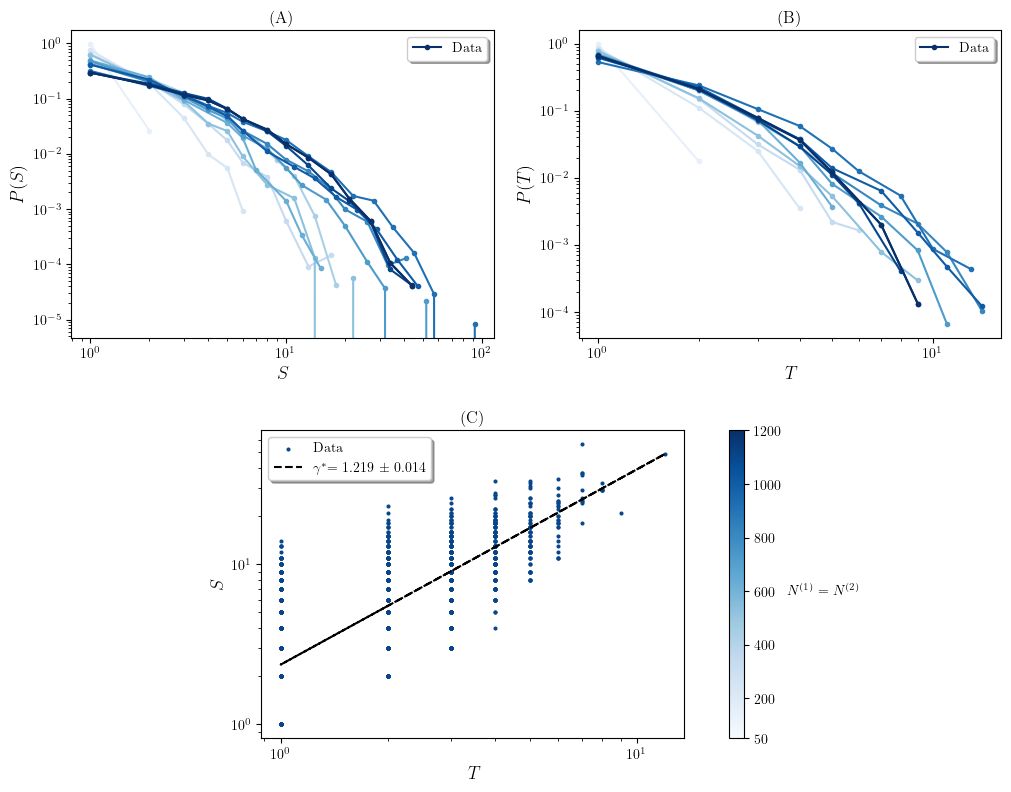

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

cmap = matplotlib.colormaps['Blues']
norm = Normalize(vmin=50, vmax=1200)

for i in range(len(size_layer)):
    color = cmap((i+1)/len(size_layer))

    avalanches_s = avalanches_s_net[i]
    avalanches_t = avalanches_t_net[i]
    s, pdf_s = pl.pdf(avalanches_s)
    t, pdf_t = pl.pdf(avalanches_t)

    ax[0].plot(s[:-1], pdf_s, marker= '.', color=color)
    ax[1].plot(t[:-1], pdf_t, marker= '.', color=color)
    if i == (len(size_layer) -1):
        ax[0].plot(s[:-1], pdf_s, marker= '.', color=color, label='Data')
        ax[1].plot(t[:-1], pdf_t, marker= '.', color=color, label='Data')

# srange= np.linspace(70, 900, 1000)
# ax[0].plot(srange, ht.power_law_pdf(srange, s_tau), color='tab:orange', label=fr'$\tau =$ {s_tau: .2f} $\pm$ {s_sigma: .2f}')



#ax[0].plot(srange, ht.stretched_exponential_pdf(srange, *popt_s), label='Fit', color='tab:orange')
#ax[0].plot(srange, lognormal_with_min(srange, 4.5, 1.5), label='Fit', color='tab:orange')
#aqui:
# trange= np.linspace(5, 28, 1000)
# ax[1].plot(trange, ht.power_law_pdf(trange, d_tau), color='tab:orange', label=fr'$\tau_{{t}} =$ {d_tau: .2f} $\pm$ {d_sigma: .2f}')


# ax[1].plot(t[:-1], lognormal_with_min(t[:-1], *popt_t), label='Fit', color='tab:orange')

# ax[0].plot(
#     ccdf_s_layers[-1][0], aval.power_func(ccdf_s_layers[-1][0], *popt_s), label=fr'$\tau=$ {-popt_s[1] +1: .2f}', color='tab:orange', linewidth=3)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].set_ylim((1e-4,1))

ax[0].set_xlabel(r'$S$', fontsize=13)
ax[0].set_ylabel(r'$P(S)$', fontsize=13)

ax[0].legend()
ax[0].set_title('(A)')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
#ax[1].set_ylim((1e-4,1))

ax[1].set_xlabel(r'$T$', fontsize=13)
ax[1].set_ylabel(r'$P(T)$', fontsize=13)

ax[1].legend()
ax[1].set_title('(B)')

ax_inset = ax[0].inset_axes([0.45, -1.3, 1., 1])

avalanches_s = avalanches_s_net[-1]
avalanches_t = avalanches_t_net[-1]

popt_couple, pcov_couple = curve_fit(ht.power_law_func, avalanches_t, avalanches_s, p0=[1, 1])
perr_couple = np.sqrt(np.diag(pcov_couple))


ax_inset.scatter(avalanches_t, avalanches_s, marker= '.', color=cmap((10+1)/12), s=15, label='Data')

# a = popt_couple[0]
# ax_inset.plot(avalanches_t, ht.power_law_func(avalanches_t, a, gamma), color='tab:orange', label=fr'$\gamma=$ {gamma_float.nominal_value: .2f} $\pm$  {gamma_float.std_dev: .2f}')


ax_inset.plot(avalanches_t, ht.power_law_func(avalanches_t, *popt_couple), color='k', label=fr'$\gamma^{{*}}$={popt_couple[1]: .3f} $\pm$ ${perr_couple[1]: .3f}$', linestyle='--')


ax_inset.set_xscale('log')
ax_inset.set_yscale('log')
ax_inset.set_ylabel(r'$S$', fontsize=13)
ax_inset.set_xlabel(r'$T$', fontsize=13)
ax_inset.set_title('(C)')
ax_inset.legend()

cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax_inset, anchor=(2.25,0.0))

# Adicione thicks personalizados para o colorbar
cbar.set_ticks([50, 200, 400, 600, 800, 1000, 1200])
cbar.set_label(r'$N^{(1)} = N^{(2)}$', rotation=0, labelpad=30)

fig.savefig('../plots/power_law_no_trained.pdf')